# FCSS Final Project - Group 9

# Analyzing unemployment and google search trends data

## Required imports to do the analysis 
#### (we assume that these packages are already installed, if not they have to be installed first with pip install + packages name)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pycountry
import pycountry_convert as pc_c
import matplotlib.colors as mcolors
import geopandas as gpd

## Preperation for the analysis to convert the ISO Country codes

In [2]:
def country_name_to_iso3(country_name: str) -> str:
    
    result = pycountry.countries.search_fuzzy(country_name)
    return result[0].alpha_3 if result else None

In [3]:
def get_country_code2(alpha3_codes: list[str]) -> list[str]:

    return [pc_c.country_alpha3_to_country_alpha2(code) for code in alpha3_codes]

In [4]:
def map_country_to_continent(alpha3_codes: list[str]) -> list[str]:

    continent_codes = [pc_c.country_alpha2_to_continent_code(code) for code in get_country_code2(alpha3_codes)]
    return [pc_c.convert_continent_code_to_continent_name(code) for code in continent_codes]

## Simple line plot of unemployment rates over time

In [5]:
def line_plot_unemployment(file_path: str,
                           start_year: int,
                           end_year: int,
                           country_names: list[str]) -> None:

    df = pd.read_csv(file_path)
    
    
    df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y-%m')
    
    
    start_date = pd.to_datetime(f"{start_year}-01", format='%Y-%m')
    end_date = pd.to_datetime(f"{end_year}-12", format='%Y-%m')
    df = df[(df['TIME_PERIOD'] >= start_date) & (df['TIME_PERIOD'] <= end_date)]
    
    
    iso3_list = []
    for name in country_names:
        iso3 = country_name_to_iso3(name)
        iso3_list.append(iso3)
    
    
    df = df[df['REF_AREA'].isin(iso3_list)]
    
    
    df_pivot = df.pivot(index='TIME_PERIOD', columns='REF_AREA', values='OBS_VALUE')
    
    
    df_pivot.plot(figsize=(10, 6))
    plt.title("Unemployment Rate")
    plt.xlabel("Year")
    plt.ylabel("Unemployment Rate (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

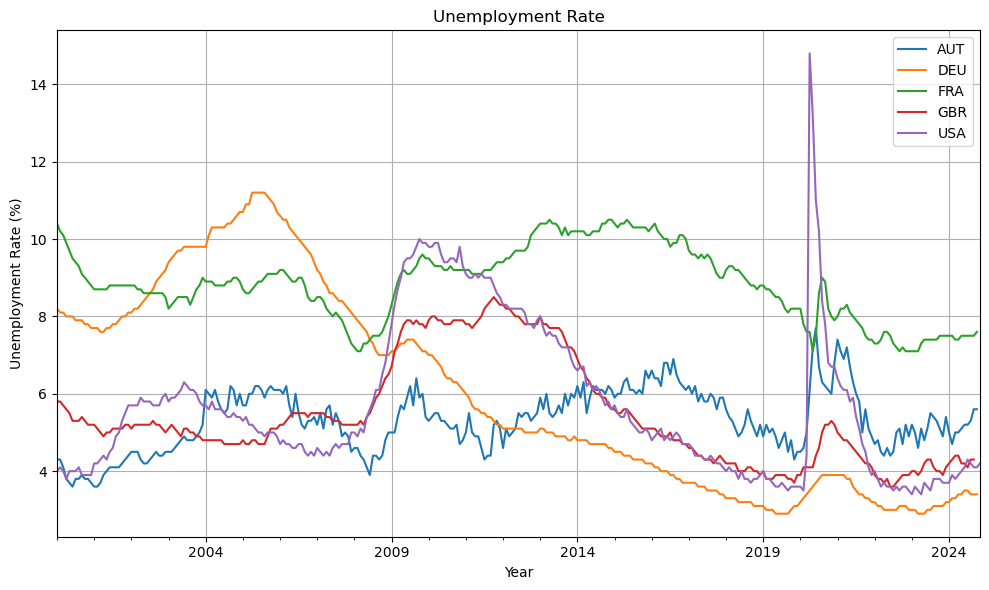

In [6]:
line_plot_unemployment(
        file_path="OECD.SDD.TPS,DSD_LFS@DF_IALFS_INDIC,1.0+.UNE_LF_M...Y._T.Y_GE15..M.csv",
        start_year=2000,
        end_year=2024,
        country_names=["Austria", "Germany", "USA", "England", "France"]
    )

## Simple line plot of unemployment rates of different age groups

In [7]:
def plot_unemployment_by_age_group(file_path: str,
                                   start_year: int,
                                   end_year: int,
                                   country_name: str,
                                   sex: str = "Total") -> None:
    
    sex = sex.capitalize()

    
    df = pd.read_csv(file_path)

    
    df_filt = df[
        (df["unit"] == "Percentage of population in the labour force") &
        (df["sex"] == sex) &
        (df["geo"] == country_name) &
        (df["TIME_PERIOD"] >= start_year) &
        (df["TIME_PERIOD"] <= end_year) &
        (df["age"].isin([
            "From 15 to 24 years",
            "From 25 to 54 years",
            "From 55 to 74 years",
            "From 15 to 74 years"
        ]))
    ].copy()  

    
    df_filt.loc[:, "age"] = df_filt["age"].replace(
        "From 15 to 74 years", "Total (From 15 to 74 years)"
    )

    
    df_pivot = df_filt.pivot(
        index="TIME_PERIOD",
        columns="age",
        values="OBS_VALUE"
    )

    
    plt.figure(figsize=(10, 6))
    df_pivot.plot(marker='o', ax=plt.gca())

    
    plt.title(
        f"Unemployment rate by age group, {country_name}, "
        f"{start_year}–{end_year}\n(percentage of the labour force)"
    )
    plt.xlabel("Year")
    plt.ylabel("Unemployment Rate (%)")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

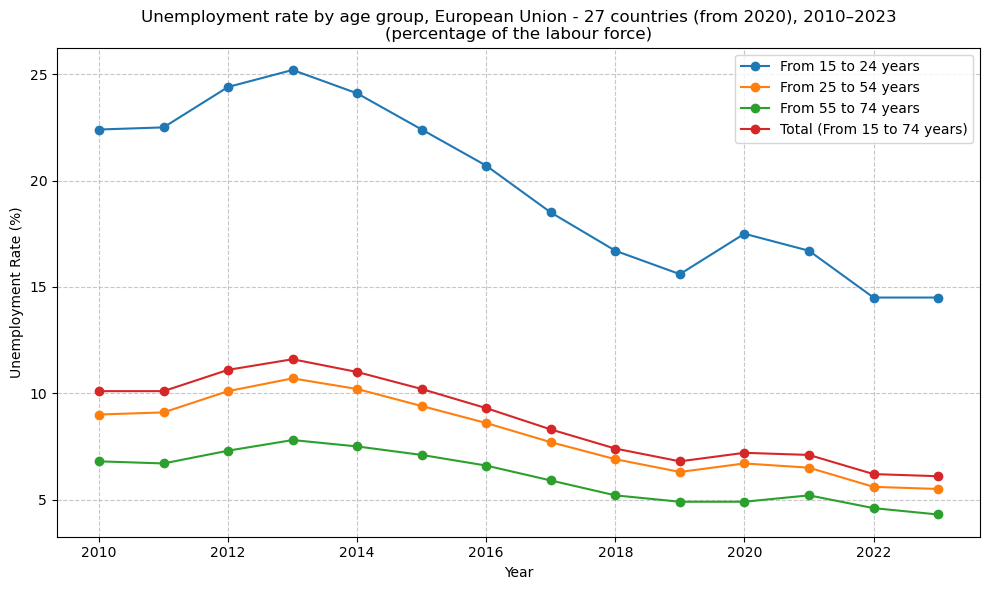

In [8]:
plot_unemployment_by_age_group(
        file_path="estat_une_rt_a_en.csv",
        start_year=2010,
        end_year=2023,
        country_name="European Union - 27 countries (from 2020)",
        sex="total"
    )

## Bar Chart of unemployment rates with a comparison between gender

In [9]:
def bar_chart_unemployment_by_sex(file_path: str,
                                  year: int,
                                  country_names: list[str] = []) -> None:

    df = pd.read_csv(file_path)

    
    df_filt = df[
        (df["TIME_PERIOD"] == year)
        & (df["age"] == "From 15 to 74 years")
        & (df["unit"] == "Percentage of population in the labour force")
    ]

    
    if country_names:
        df_filt = df_filt[df_filt["geo"].isin(country_names)]

    
    df_pivot = df_filt.pivot_table(
        index="geo",
        columns="sex",
        values="OBS_VALUE", 
    ).fillna(0)

    
    _, ax = plt.subplots(figsize=(12, 6))

 

    countries = df_pivot.index  
    for i, country in enumerate(countries):
        total = df_pivot.loc[country, "Total"]
        males = df_pivot.loc[country, "Males"]
        females = df_pivot.loc[country, "Females"]

        
        ax.bar(i, total, color="purple", label="Total" if i == 0 else "")

        
        ax.scatter(i, males, color="blue", label="Males" if i == 0 else "", zorder=3)

        
        ax.scatter(i, females, color="gold", label="Females" if i == 0 else "", zorder=3)

    
    ax.set_title(
        f"Unemployment rate by sex, {year} (age group 15–74, % of labour force)"
    )
    ax.set_xlabel("Country")
    ax.set_ylabel("Unemployment Rate (%)")

    
    ax.set_xticks(range(len(countries)))
    ax.set_xticklabels(countries, rotation=45, ha="right")

    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

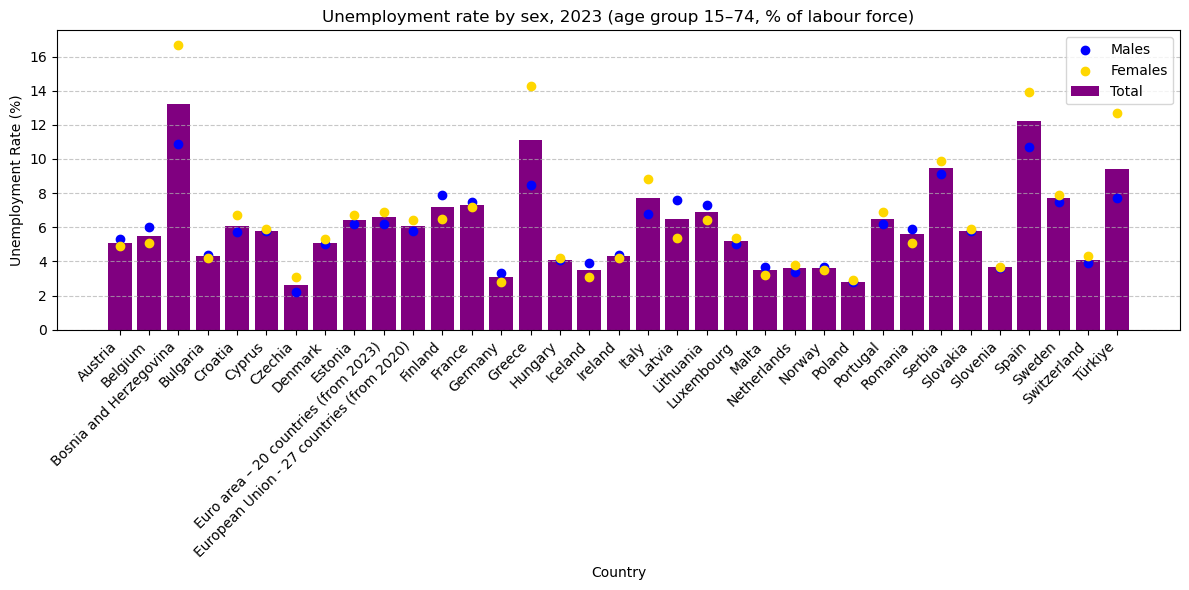

In [10]:
bar_chart_unemployment_by_sex(
        file_path="estat_une_rt_a_en.csv",
        year=2023,
        country_names=[]
    )

## Bar Chart that shows how the educational level influences the unemployment rate

In [11]:
def bar_chart_unemployment_by_education(file_path: str, 
                                        year: int, 
                                        country_names: list[str] = []) -> None:

    
    df = pd.read_csv(file_path)

    
    df_filt = df[
        (df["TIME_PERIOD"] == year)
        & (df["age"] == "From 15 to 74 years")
        & (df["sex"] == "Total")
        & (df["unit"] == "Percentage of population in the labour force")
    ]

    
    if country_names:
        df_filt = df_filt[df_filt["geo"].isin(country_names)]

    
    df_pivot = df_filt.pivot_table(
        index="geo",
        columns="isced11",
        values="OBS_VALUE"
    ).fillna(0)

    
    education_levels = [
        "Less than primary, primary and lower secondary education (levels 0-2)",
        "Upper secondary and post-secondary non-tertiary education (levels 3 and 4)",
        "Tertiary education (levels 5-8)"
    ]

    
    countries = list(df_pivot.index)       
    x_positions = list(range(len(countries)))  
    bar_width = 0.25                       
    _, ax = plt.subplots(figsize=(12, 6))

    
    offsets = [-bar_width, 0, bar_width]
    colors = ["purple", "steelblue", "gold"]

    
    for i, edu_level in enumerate(education_levels):
        bar_positions = [x + offsets[i] for x in x_positions]
        ax.bar(
            bar_positions,
            df_pivot[edu_level],
            width=bar_width,
            color=colors[i],
            label=edu_level
        )

    
    ax.set_title(f"Unemployment Rate by Education Level, {year}\n(Age 15–74, % of labour force)")
    ax.set_xlabel("Country")
    ax.set_ylabel("Unemployment Rate (%)")

    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(countries, rotation=45, ha="right")

    ax.legend(title="Level of Education")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

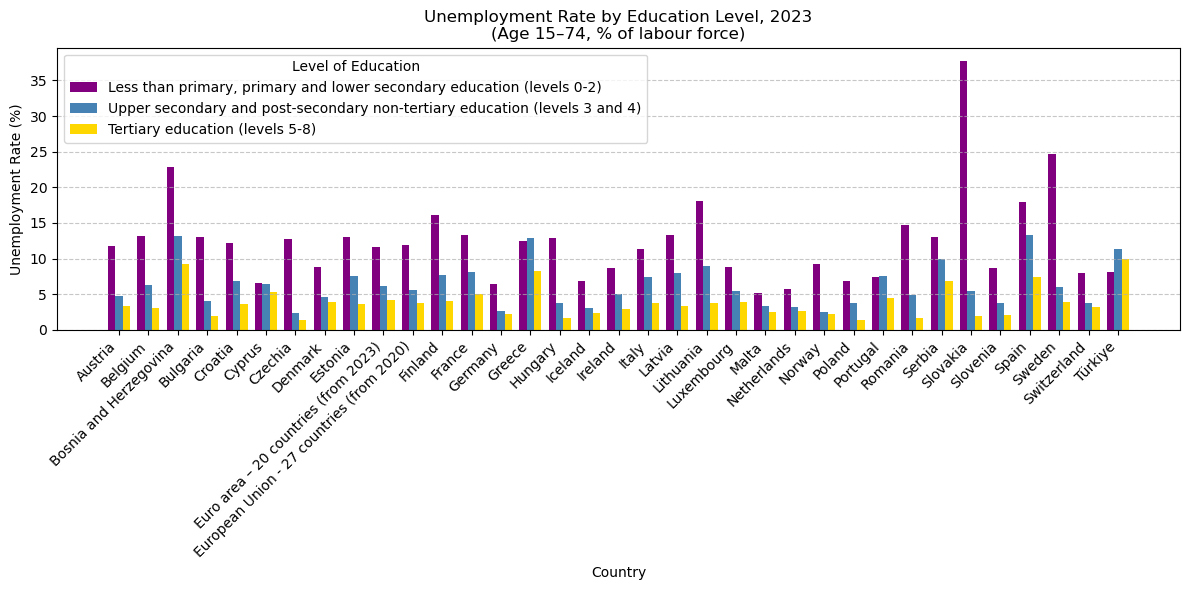

In [12]:
bar_chart_unemployment_by_education(
        file_path="estat_une_educ_a_en.csv",
        year=2023,
        country_names=[]
    )

## Scatter plot that shows the relation between the GPD and public unemployment spendigs

In [13]:
def scatter_plot_gdp_vs_unemployment(
    gdp_data: str,
    unempl_data: str,
    gdp_year: str = "2019 [YR2019]",
    unempl_year: int = 2019
) -> None:

    
    gdp_data_df = pd.read_csv(gdp_data)
    unempl_data_df = pd.read_csv(unempl_data)
    
    
    gdp_data_df = gdp_data_df[["Country Code", gdp_year]]
    gdp_data_df.rename(columns={"Country Code": "REF_AREA", gdp_year: "GDP"}, inplace=True)
    gdp_data_df["GDP"] = pd.to_numeric(gdp_data_df["GDP"], errors="coerce")
    
    
    unempl_data_df = unempl_data_df[unempl_data_df["TIME_PERIOD"] == unempl_year]
    unempl_data_df = unempl_data_df[["REF_AREA", "OBS_VALUE"]]
    
    
    merged_data = pd.merge(gdp_data_df, unempl_data_df, on="REF_AREA", how="inner")
    merged_data["Unemployment_Payment_Absolute"] = (
        merged_data["GDP"] * merged_data["OBS_VALUE"] / 100
    )
    
    
    merged_data["Continent"] = map_country_to_continent(merged_data["REF_AREA"].tolist())
    
    
    correlation = merged_data["GDP"].corr(merged_data["Unemployment_Payment_Absolute"])
    
    
    plt.figure(figsize=(10, 7))
    
    
    continent_colors = {
        "Asia": "red",
        "Europe": "blue",
        "Africa": "green",
        "North America": "orange",
        "South America": "purple",
        "Oceania": "brown"
    }
    
    
    for continent, color in continent_colors.items():
        subset = merged_data[merged_data["Continent"] == continent]
        plt.scatter(
            subset["GDP"],
            subset["Unemployment_Payment_Absolute"],
            label=continent,
            alpha=0.7,
            color=color
        )
    
    
    plt.xscale("log")
    plt.yscale("log")
    
    
    plt.xlabel(f"GDP in {gdp_year[:4]} (Log Scale)", fontsize=12)
    plt.ylabel(f"Unemployment Payment {unempl_year} (Log Scale)", fontsize=12)
    plt.title(
        f"Scatter Plot: GDP vs. Unemployment Payments (Log Scale)\n"
        f"Correlation Coefficient: {correlation:.2f}",
        fontsize=14
    )
    
    
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    
    
    plt.tight_layout()
    plt.show()

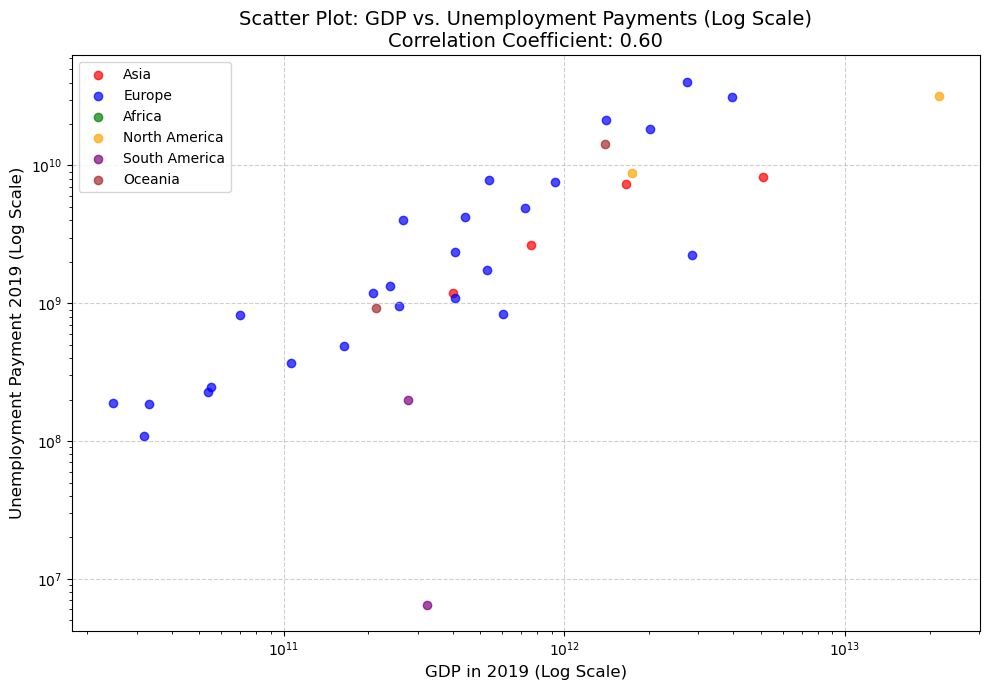

In [14]:
scatter_plot_gdp_vs_unemployment(
    gdp_data='e8038893-8b9e-403f-a6bb-a59b05c2baed_Data.csv', 
    unempl_data='OECD.ELS.SPD,DSD_SOCX_AGG@DF_SOCX_AGG,+.A..PT_B1GQ.ES10._T.TP71._Z.csv', 
    gdp_year='2019 [YR2019]',
    unempl_year=2019)

## Scatter plot that shows the relation between the unemployment rate and inflation 

In [15]:
def scatter_plot_unemployment_vs_inflation(
    unemp_file: str,
    inflation_file: str,
    start_year: int = 2012
) -> None:

    df = pd.read_csv(unemp_file)
    df = df[["TIME_PERIOD", "REF_AREA", "OBS_VALUE"]]
    df["year"] = df["TIME_PERIOD"].str[:4].astype(int)
    df = df[df["year"] >= start_year]
    df_avg = (
        df.groupby(["year", "REF_AREA"], as_index=False)["OBS_VALUE"]
        .mean()
    )

    
    df_2 = pd.read_csv(inflation_file)
    df_2["year"] = df_2["TIME_PERIOD"].astype(int)
    df_2 = df_2[["year", "geo", "OBS_VALUE"]]

    
    def iso3_to_iso2(iso3_code: str) -> str | None:
        try:
            return pycountry.countries.get(alpha_3=iso3_code).alpha_2
        except:
            return None

    df_avg["iso2"] = df_avg["REF_AREA"].apply(iso3_to_iso2)
    df_avg: DataFrame = df_avg
    df_avg = df_avg.loc[df_avg["iso2"].notna()]

    
    df_avg = df_avg.rename(columns={"OBS_VALUE": "unemp_rate"})
    df_2 = df_2.rename(columns={"OBS_VALUE": "inflation_rate"})

    
    merged_df = pd.merge(
        df_avg,
        df_2,
        left_on=["iso2", "year"],
        right_on=["geo", "year"],
        how="inner"
    )

    correlation2 = merged_df["unemp_rate"].corr(merged_df["inflation_rate"])

    
    eu_iso2 = {
        "AT", "BE", "BG", "HR", "CY", "CZ", "DK", "EE", "FI",
        "FR", "DE", "EL", "HU", "IE", "IT", "LV", "LT", "LU",
        "MT", "NL", "PL", "PT", "RO", "SK", "SI", "ES", "SE"
    }

    
    eu_df = merged_df[merged_df["iso2"].isin(eu_iso2)]
    non_eu_df = merged_df[~merged_df["iso2"].isin(eu_iso2)]

    
    plt.figure(figsize=(10, 7))

    plt.scatter(
        eu_df["unemp_rate"], eu_df["inflation_rate"],
        alpha=0.7, color="blue", label="EU Countries"
    )

    plt.scatter(
        non_eu_df["unemp_rate"], non_eu_df["inflation_rate"],
        alpha=0.7, color="red", label="Non-EU Countries"
    )

    
    plt.xlabel("Unemployment Rate (%)", fontsize=12)
    plt.ylabel("Inflation Rate (%)", fontsize=12)
    plt.title(f"Unemployment vs. Inflation (All Countries/Years)" f" Correlation Coefficient: {correlation2:.2f}",
               fontsize=14)

    
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

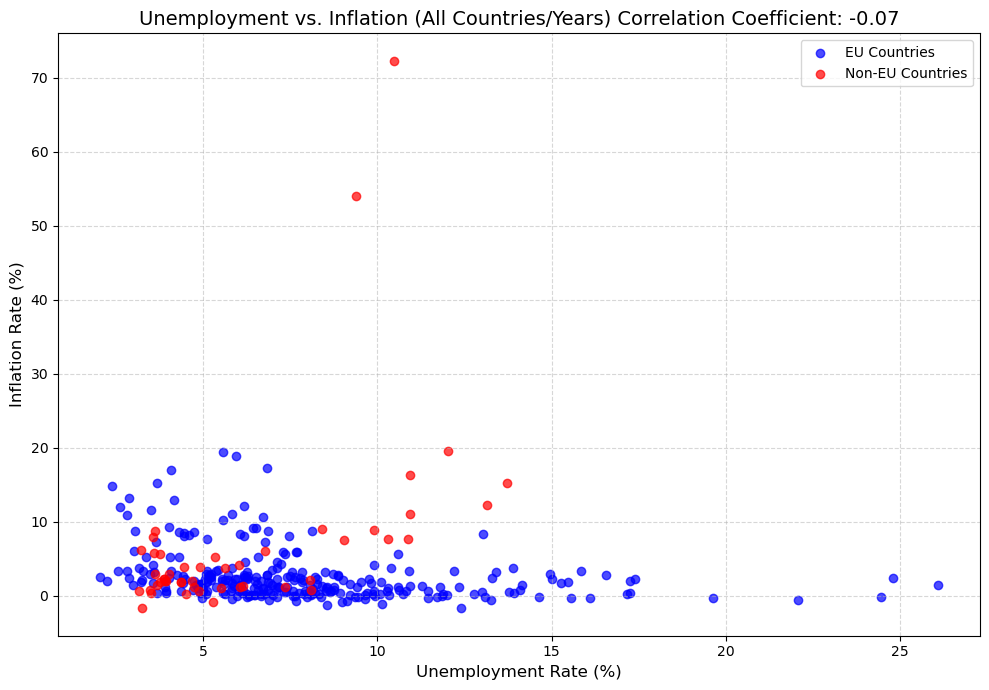

In [16]:
scatter_plot_unemployment_vs_inflation("OECD.SDD.TPS,DSD_LFS@DF_IALFS_INDIC,1.0+.UNE_LF_M...Y._T.Y_GE15..M.csv",
                                       "estat_tec00118_en.csv")

## Unemployment Rate vs Google Search Trends for "Arbeitslosengeld" (Austria)

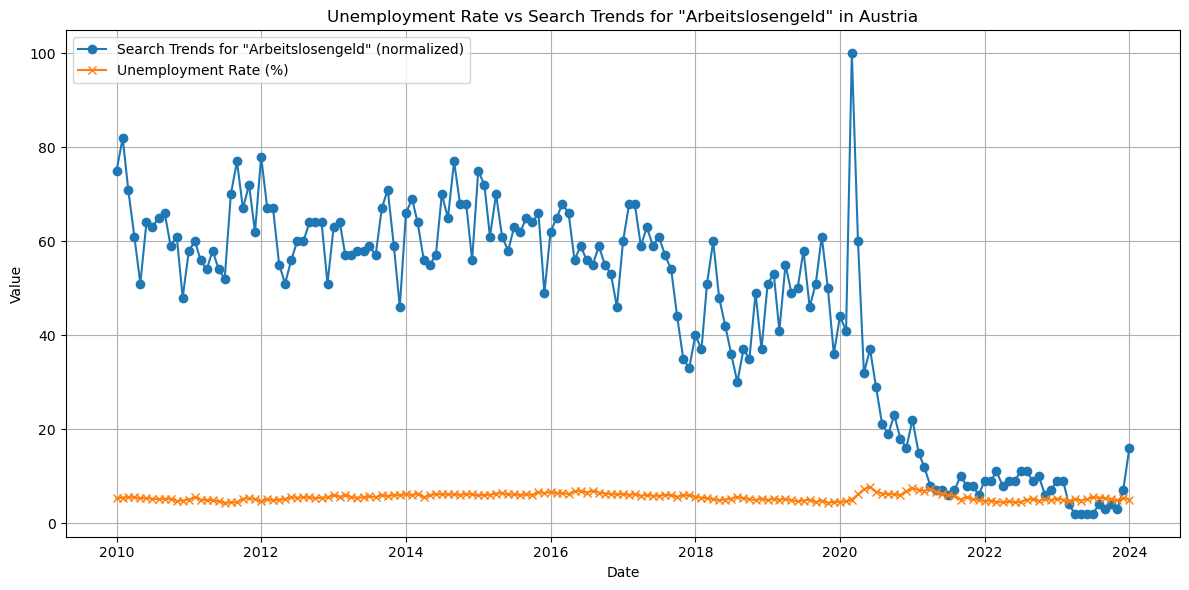

In [17]:
# File paths
trends_file = 'Arbeitslosengeld_Trends.csv'
unemployment_file = 'OECD.SDD.TPS,DSD_LFS@DF_IALFS_INDIC,1.0+.UNE_LF_M...Y._T.Y_GE15..M.csv'

# Google Trends data
trends_data = pd.read_csv(trends_file, skiprows=2)
trends_data.columns = ['Date', 'Search Trends']
trends_data['Date'] = pd.to_datetime(trends_data['Date'])

# Unemployment data
unemployment_data = pd.read_csv(unemployment_file)
unemployment_data_cleaned = unemployment_data[unemployment_data['REF_AREA'] == 'AUT'][['TIME_PERIOD', 'OBS_VALUE']]
unemployment_data_cleaned.columns = ['Date', 'Unemployment Rate (%)']
unemployment_data_cleaned['Date'] = pd.to_datetime(unemployment_data_cleaned['Date'])

# Merge datasets
merged_data = pd.merge(trends_data, unemployment_data_cleaned, on='Date', how='inner')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], merged_data['Search Trends'], label='Search Trends for "Arbeitslosengeld" (normalized)', marker='o')
plt.plot(merged_data['Date'], merged_data['Unemployment Rate (%)'], label='Unemployment Rate (%)', marker='x')
plt.title('Unemployment Rate vs Search Trends for "Arbeitslosengeld" in Austria')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Better visualization of COVID spike in 2020

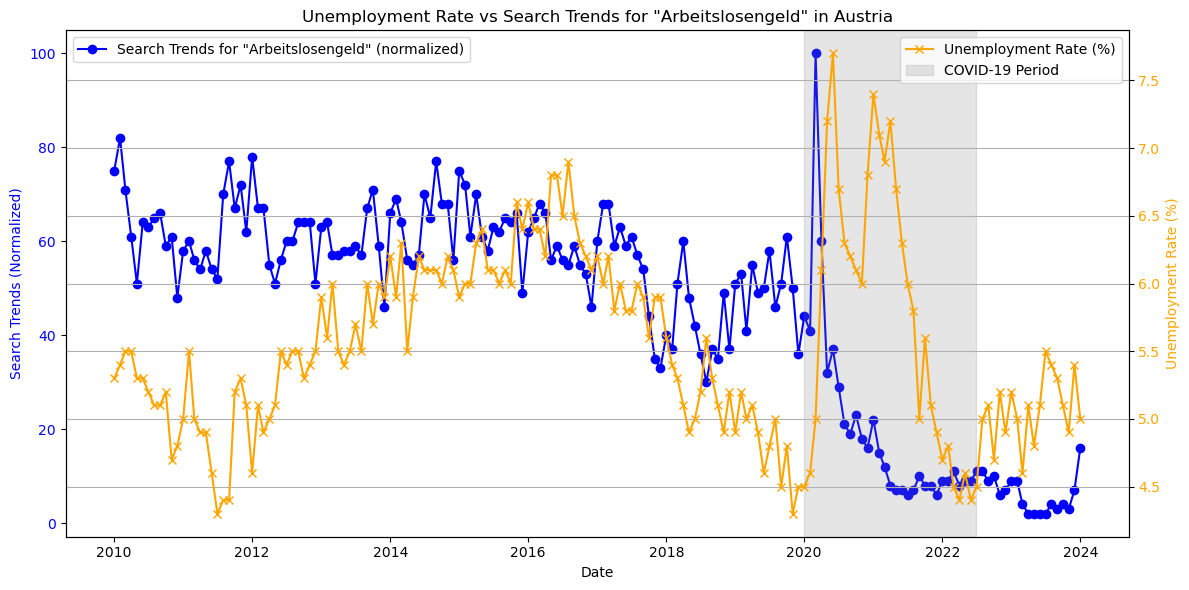

In [18]:
# Create a figure and axis with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# First y-axis: Google Search Trends
ax1.plot(
    merged_data['Date'], merged_data['Search Trends'],
    label='Search Trends for "Arbeitslosengeld" (normalized)', marker='o', color='blue'
)
ax1.set_ylabel('Search Trends (Normalized)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Second y-axis: Unemployment Rate
ax2 = ax1.twinx()
ax2.plot(
    merged_data['Date'], merged_data['Unemployment Rate (%)'],
    label='Unemployment Rate (%)', marker='x', color='orange'
)
ax2.set_ylabel('Unemployment Rate (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Highlight COVID-19 period
plt.axvspan(pd.to_datetime('2020-01-01'), pd.to_datetime('2022-06-30'),
            color='gray', alpha=0.2, label='COVID-19 Period')

plt.title('Unemployment Rate vs Search Trends for "Arbeitslosengeld" in Austria')
ax1.set_xlabel('Date')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()

## Correlation Analysis

In [19]:
correlation = merged_data[['Search Trends', 'Unemployment Rate (%)']].corr()
print(correlation)

                       Search Trends  Unemployment Rate (%)
Search Trends               1.000000               0.125705
Unemployment Rate (%)       0.125705               1.000000


## Lag Analysis

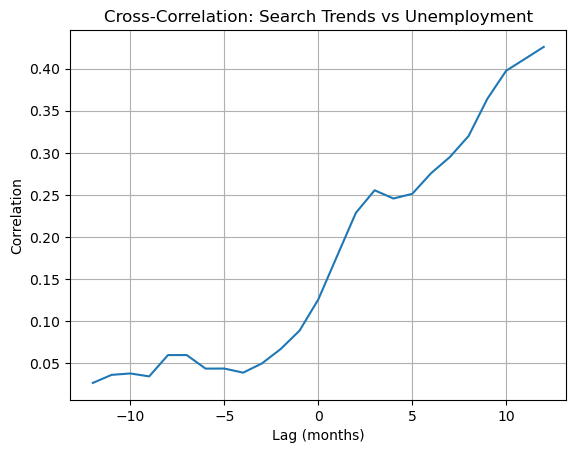

In [20]:
from statsmodels.tsa.stattools import ccf

lags = range(-12, 13)  # Test for +/- 12 months
cross_correlation = [merged_data['Search Trends'].shift(l).corr(merged_data['Unemployment Rate (%)']) for l in lags]
plt.plot(lags, cross_correlation)
plt.title('Cross-Correlation: Search Trends vs Unemployment')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

## Seasonality Analysis of Search Trends

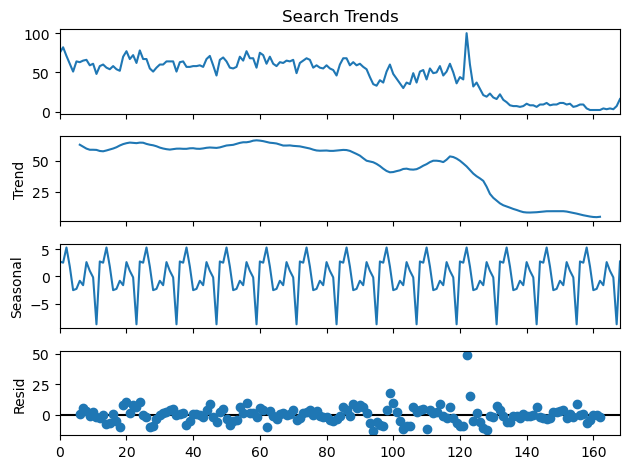

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(merged_data['Search Trends'], model='additive', period=12)
decomposition.plot()
plt.show()

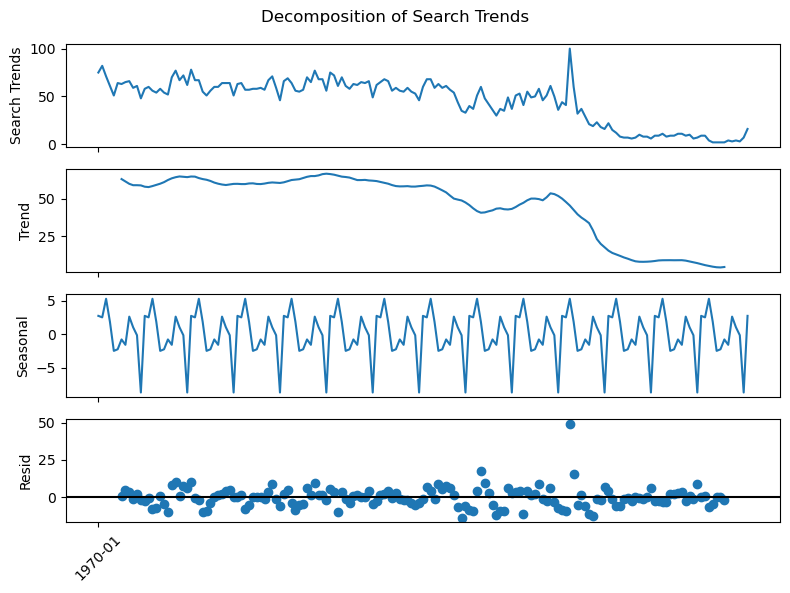

In [22]:
import matplotlib.dates as mdates

decomposition = seasonal_decompose(merged_data['Search Trends'], model='additive', period=12)

# Decompose components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 6))

# Plot: original data
axes[0].plot(merged_data.index, merged_data['Search Trends'])
axes[0].set_ylabel('Search Trends')

# Plot: trend
axes[1].plot(merged_data.index, trend)
axes[1].set_ylabel('Trend')

# Plot: seasonality
axes[2].plot(merged_data.index, seasonal)
axes[2].set_ylabel('Seasonal')

# Plot: residual
axes[3].plot(merged_data.index, residual, 'o')
axes[3].set_ylabel('Resid')
axes[3].axhline(y=0, color='k', linestyle='-')

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y-%m')

axes[3].xaxis.set_major_locator(years)
axes[3].xaxis.set_major_formatter(years_fmt)

plt.setp(axes[3].xaxis.get_majorticklabels(), rotation=45)

plt.suptitle('Decomposition of Search Trends')
plt.tight_layout()
plt.show()

## Geographical Map of unemployment rates in Austria

<Figure size 1200x800 with 0 Axes>

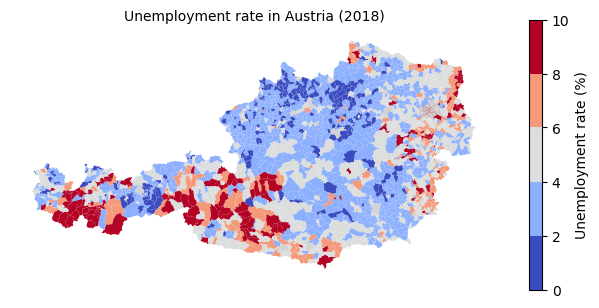

<Figure size 1200x800 with 0 Axes>

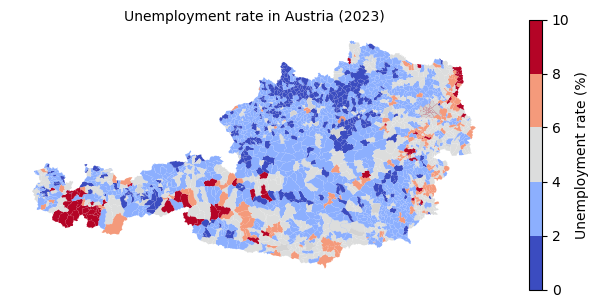

In [23]:
unempl_data = pd.read_excel("Arbeitslosenquoten_Statistik_Austria_2018.xlsx")
austria_map = gpd.read_file("gemeinden_95_geo.json")

unempl_data = unempl_data.rename(columns={"GEMEINDE": "name"})
austria_map_merged = austria_map.merge(unempl_data[['name', 'ALO_QUOTE']], on='name', how='left')

breaks = [0, 2, 4, 6, 8, 10]
norm = mcolors.BoundaryNorm(boundaries=breaks, ncolors=256)

plt.figure(figsize=(12, 8))
austria_map_merged.plot(
    column='ALO_QUOTE',
    cmap='coolwarm',
    legend=True,
    legend_kwds={
        'orientation': "vertical",
        'boundaries': breaks,
        'label': "Unemployment rate (%)",
        'shrink': 0.6,
        'aspect': 20,
        'pad': 0.05
    },
    missing_kwds={"color": "lightgrey", "label": "No Data"},
    norm=norm
)
plt.title(
    "Unemployment rate in Austria (2018)",
    fontsize=10
)
plt.axis('off')
plt.tight_layout()
plt.show()

unempl_data = pd.read_excel("Arbeitslosenquoten_Statistik_Austria.xlsx")
unempl_data = unempl_data.rename(columns={"GEMEINDE": "name"})
austria_map_merged = austria_map.merge(unempl_data[['name', 'ALO_QUOTE']], on='name', how='left')

breaks = [0, 2, 4, 6, 8, 10]
norm = mcolors.BoundaryNorm(boundaries=breaks, ncolors=256)

plt.figure(figsize=(12, 8))
austria_map_merged.plot(
    column='ALO_QUOTE',
    cmap='coolwarm',
    legend=True,
    legend_kwds={
        'orientation': "vertical",
        'boundaries': breaks,
        'label': "Unemployment rate (%)",
        'shrink': 0.6,
        'aspect': 20,
        'pad': 0.05
    },
    missing_kwds={"color": "lightgrey", "label": "No Data"},
    norm=norm
)
plt.title(
    "Unemployment rate in Austria (2023)",
    fontsize=10
)
plt.axis('off')
plt.tight_layout()
plt.show()
